# Работа с ошибками 
Работа с один из обязательных шагов в работе с текстами. В любом массиве текстов всегда присутствуют ошибки.
Т.к. в гастоящее время все книги переводятся в цифровые форматы, корректность их конвертации может происходить с большим количеством ошибок. 
Если вы работаете с текстом в виде сканированных страниц, то перевод его в посимвольный формат порождает ошибки.
Ошибки связанные с некорректным распознаванием символов и в словах появляются артефакты. 
Появляются слитые слова из нескольких слов. При распознавании блочного текста может перекрываться содержание блоков.
В текстах с самого начала введенных с помощью редакторов, встречаются опечатки. Иногда в очень больших количествах. При этом если текст набивался с переносом частей слов, можно встретить обрывки слов.


Автокорректор ошибок на Python
нужно было как-то формально назвать это :)

На основе блокнота Питера Норвига, Google

Перевод и дополнения: Ян Пиле, НИУ ВШЭ
DISCLAIMER

Сразу предупрежу, что это мой скромный кавер на материал - https://norvig.com/spell-correct.html  директора по исследованиям Google - Питера Норвига. Русскоязычной версии такого крутого рассказа еще не было, так что here we are!
Статистическая обработка естественного языка в Python.
или
Как делать всякое со словами. И Counter'ами (aka Счетчиками).
или 

In [1]:
# Импортируй и властвуй
%pylab inline
import re
import math
import string
from collections import Counter
import requests

Populating the interactive namespace from numpy and matplotlib



(1) Данные: Текст и Слова

Прежде чем что-то делать со словами(править опечатки, например), надо эти слова откуда-то взять. Придется найти некий текст, возможно - из файла, а возможно - лежащий где-то на просторах интернета. Затем нужно этот текст разбить на слова. Мы позаимствуем текст у Питера Норвига - автора одного из очень популярных алгоритмов проверки правописания (и директора по исследованиям Google) :) вот текст. Считаем его из интернета и посмотрим, насколько фрагмент текста велик (в количестве символов):


In [2]:
TEXT = requests.get('https://norvig.com/big.txt').text
len(TEXT)

6488666



Текст огромен - более 6 млн. символов.

Теперь нужно разбить текст на слова (Ну, или если быть чуть более формальным, токены). Пока что мы не будем сильно задумываться о том, что в тексте есть пунктуация, цифры и прочие символы - сосредоточимся только на словах, состоящих из букв.


In [3]:
def tokens(text):
    """Возвращает список токенов (подряд идущих буквенных последовательностей) в тексте. 
       Текст при этом приводится к нижнему регистру."""
    return re.findall(r'[a-z]+', text.lower()) 

In [4]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [5]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

Остался миллион различных слов. Вот первые 10:

In [6]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']




Хочу заметить, что сейчас слова появляются в нашем списке в том порядке, как они располагались в тексте
(2) Модель: Мешок слов (aka Bag of Words)

Мы создали список WORDS - список слов в том порядке, как они следуют в TEXT. Мы можем использовать этот список в качестве порождающей модели (generative model) текста. Язык - очень сложная штука и мы создаем крайне упрощенную модель языка, которая может ухватить часть этой сложной структуры. В модели мешка слов , мы полностью игнорируем порядок слов, зато соблюдаем их частоту. Представить это можно себе так: вы берете все слова текста и забрасываете их в мешок. Теперь, если вы хотите сгенерировать предложение с помощью этого мешка, вы просто трясете его(слова там перемешиваются) и достаете указанное количество слов по одному (мешок непрозрачный, так что слоа вы достаете наугад). Почти наверное полученное предложение будет грамматически некорректным, но слова в этом предложении будут в +- правильной пропорции (более частые будут встречаться чаще, более редкие - реже). Вот функция, которая сэмплирует(от англ. sample) предложение из n слов с помощью нашего мешка:


In [7]:
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))

In [8]:
sample(WORDS)

'to the the go fitting of in of did down'

Другое представление мешка слов - Counter. Это словарь, состоящий из пар {'слово': кол-во вхождений слова в текст}. Например,

In [9]:
Counter(tokens('Is this a test? It is a test!'))

Counter({'is': 2, 'this': 1, 'a': 2, 'test': 2, 'it': 1})

Counter очень похож на словарь из Python - тип dict , но у него есть ряд дополнительных методов. Давайте завернем в Counter наш список слов WORDS и посмотрим, что получится:

In [10]:
COUNTS = Counter(WORDS)
print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [11]:
for w in tokens('the rare and neverbeforeseen words'):
    print(COUNTS[w], w)

80030 the
83 rare
38313 and
0 neverbeforeseen
460 words


В 1935, лингвист Джордж Ципф отметил, что в любом большом тексте n-тое наиболее часто встречающееся слово появляется с частотой ~ 1/n от частоты наиболее часто встречающегося слова. Это наблюдение получило название Закона Ципфа, несмотря на то, что Феликс Ауэрбах заметил это еще в 1913 году. Если нарисовать частоты слов, начиная от самого часто встречающегося, на log-log-графике, они должны приблизительно следовать прямой линии, если закон Ципфа верен. Для нашего случая все, вроде бы, +- совпадает:

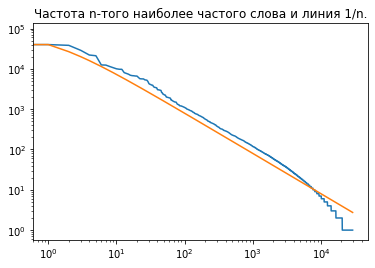

In [12]:
M = COUNTS['the']
yscale('log'); 
xscale('log'); 
title('Частота n-того наиболее частого слова и линия 1/n.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

In [13]:
# 'abcd' -> 'abcd'

3) Задача: Проверка Правописания

Для данного слова w нужно найти наиболее вероятную правку c = correct(w).

Подход: Найти все кандидаты c, достаточно близкие к w. Выбрать наиболее вероятный из них.

Осталось понять, что такое близкие и наиболее вероятный.

Применим наивный подход: всегда будем брать более близкое слово, если проверки на близость недостаточно, берем слово с максимальной частотой из WORDS. Сейчас мы будем измерять близость с помощью расстояния Левенштейна: минимального необходимого количества удалений, перестановок, вставок, и замен символов, необходимых чтобы одно слово превратить в другое. Конечно же это не единственный возможный подход. Методом проб и ошибок можно понять, что поиск слов в пределах расстояния 2 уже даст пристойные результаты (или можно почитать в литературе). Тогда остается определить функциюcorrect(w):



Функции known и edits0 простые; функция edits2 iлегко получается из функции edits1:


In [14]:
def known(words):
    "Вернуть подмножество слов, которое есть в нашем словаре."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Вернуть все строки, которые находятся на edit_distance == 0 от word (т.е., просто само слово)."
    return {word}

def edits2(word):
    "Вернуть все строки, которые находятся на edit_distance == 2 от word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}


In [15]:
def correct(word):
    "Поиск лучшего исправления ошибки для данного слова."
    # предрассчитать edit_distance==0, затем 1, затем 2; в противном случае оставить слово "как есть".
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

Функция edits1(word)должна возвращать множество слов, находящихся на расстоянии edit_distance == 1. Например для слова "wird" это множество будет включать слова "weird" (вставка буквы e) и слово "word" (замена i на o), , а также "iwrd" (перемена w и i местами); после чего может быть применена функция known для фильтрации и выбора подходящих кандидатов). Как же нам получить их? Например можно разбить исходное слово на пару всеми возможными способами (каждое разбиение даст нам пару "слов"), (a, b), первая часть - до места разбиения, а вторая - после, и в каждом месте разбиения можно: удалить, поменять местами, заменить или вставить букву:
пары: 	Ø+wird 	w+ird 	wi+rd 	wir+d	wird+Ø	Notes: (a, b) пара
удаления: 	Ø+ird	w+rd	wi+d	wir+Ø		Удаление первой буквы в b
перемена мест: 	Ø+iwrd	w+rid	wi+dr			Перемена мест двух первых букв b
замена: 	Ø+?ird	w+?rd	wi+?d	wir+?		замена буквы в начале b
вставка: 	Ø+?+wird	w+?+ird	wi+?+rd	wir+?+d	wird+?+Ø	Вставка буквы между a и b 

In [16]:
def edits1(word):
    "Возвращает список всех строк на расстоянии edit_distance == 1 от word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Возвращает список всех возможных разбиений слова на пару (a, b)."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [17]:
splits('wird')

[('', 'wird'), ('w', 'ird'), ('wi', 'rd'), ('wir', 'd'), ('wird', '')]

In [18]:
print(edits0('wird'))

{'wird'}


In [19]:
print(edits1('wird'))

{'wizrd', 'wiad', 'mwird', 'wirdd', 'wuird', 'wqrd', 'wcrd', 'wrd', 'wirx', 'dird', 'wjird', 'wiyd', 'wiard', 'widr', 'wzrd', 'wiro', 'ewird', 'awird', 'wisd', 'uwird', 'wirb', 'wirdo', 'wirpd', 'oird', 'widrd', 'wirdt', 'wiurd', 'wimd', 'wirdb', 'wjrd', 'wirw', 'wzird', 'kwird', 'wfird', 'wiryd', 'pird', 'wiord', 'wirv', 'aird', 'wirz', 'winrd', 'wild', 'wirl', 'wirvd', 'wicrd', 'wirdf', 'vwird', 'wiru', 'wvird', 'wiod', 'wimrd', 'wirdk', 'waird', 'yird', 'wijrd', 'wirdu', 'hwird', 'wirdz', 'rwird', 'wurd', 'ywird', 'wirod', 'wibd', 'wirp', 'wifrd', 'iwrd', 'twird', 'woird', 'wiwd', 'wiprd', 'wirf', 'wirxd', 'wrrd', 'wsrd', 'wiri', 'wirdr', 'wirt', 'wilrd', 'wira', 'wirnd', 'mird', 'wkird', 'wirs', 'wibrd', 'wirdx', 'wirm', 'gwird', 'wirr', 'wirrd', 'wirgd', 'wiry', 'wpird', 'wfrd', 'wire', 'wigrd', 'wiud', 'eird', 'zird', 'lird', 'sird', 'wipd', 'witd', 'wdird', 'weird', 'wirdm', 'wmird', 'wiird', 'wwrd', 'wird', 'xwird', 'ird', 'widd', 'ward', 'fwird', 'wxrd', 'lwird', 'wyird', 'wir

In [20]:
print(len(edits2('wird')))

24254


In [21]:
tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?')

['speling',
 'errurs',
 'in',
 'somethink',
 'whutever',
 'unusuel',
 'misteakes',
 'everyware']

In [22]:
list(map(correct, tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?')))

['spelling',
 'errors',
 'in',
 'something',
 'whatever',
 'unusual',
 'mistakes',
 'everywhere']



Можно ли сделать выходные данные покрасивее?


In [23]:
def correct_text(text):
    "Исправить все слова с опечатками в тексте."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    "Исправить слово word в match-группе, сохранив регистр: upper/lower/title."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Возвращает функцию регистра по тексту: upper, lower, title, или str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [24]:
str('fhgwdjksa')

'fhgwdjksa'

In [25]:
list(map(case_of, ['UPPER', 'lower', 'Title', 'CamelCase']))

[<method 'upper' of 'str' objects>,
 <method 'lower' of 'str' objects>,
 <method 'title' of 'str' objects>,
 str]

In [26]:
correct_text('Speling Errurs IN somethink. Whutever; unusuel misteakes?')

'Spelling Errors IN something. Whatever; unusual mistakes?'

In [27]:
correct_text('Audiance sayzs: tumblr ...')

'Audience says: tumbler ...'

Уже неплохо. Возможно вы уже придумали десяток способов сделать все это получше. Я предложу один: например в тексте "three, too, one, blastoff!" вместо "too" явно нужно подставить "two", несмотря на то что слово "too" имеется в нашем словаре. Мы могли бы улучшить результат, приняв во внимание последовательность слов, а не только отдельные слова. Ну и как же мы будем выбирать скорректированные слова тогда, спросите вы? Ad-hoc подход неплохо сработал для отдельных слов, давайте поддадим немного теории.

# (4) Теория: От счетчика слов к вероятностям последовательностей слов

Нам нужно научиться подсчитывать вероятности слов,
. Делать мы это будем с помощью функции pdist, которая на вход принимает Counter (наш мешок слов) и возвращает функцию, выполняющую роль вероятностного распределения на множестве всех возможных слов. В вероятностном распределении вероятность каждого слова лежит между 0 и 1, и сложение вероятностей всех слов дает 1.

In [28]:
def pdist(counter):
    "Превращает частоты из Counter в вероятностное распределение."
    N = sum(list(counter.values()))
    return lambda x: counter[x]/N

P = pdist(COUNTS)

In [29]:
for w in tokens('"The" is the most common word in English'):
    print(P(w), w)

0.07240666434449033 the
0.008842968103249388 is
0.07240666434449033 the
0.0008215075749693518 most
0.0002596615352601365 common
0.0002696137195383996 word
0.019949605757790978 in
0.00019090098933759167 english


Итак, что же такое вероятность последовательности слов? Используем определение совместной вероятности:

Модель мешка слов подразумевает, что каждое слово из мешка достается независимо от других. Это дает нам неправильную упрощенную аппроксимацию:

Известный статистик Джордж Бокс сказал Все модели неверны, но некоторые полезны.

Как же нам посчитать

? Мы будем использовать другое название, чтобы не обманывать себя, Pwords вместо P, и посчитаем ее как произведение индивидуальных вероятностей:



In [30]:
def Pwords(words):
    "Вероятности слов, при условии, что они независимы."
    return product(P(w) for w in words)

def product(nums):
    "Перемножим числа.  (Это как `sum`, только с умножением.)"
    result = 1
    for x in nums:
        result *= x
    return result

In [31]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a neverbeforeseen test']

for test in tests:
    print(Pwords(tokens(test)), test)

2.983396332800731e-11 this is a test
8.637472023018802e-16 this is a unusual test
0.0 this is a neverbeforeseen test




ВОУ—кажется, присвоить последнюю вероятность 0, неправильно; Она просто должна быть маленькой. К этому вернемся попозже. Ну а другие вероятности кажутся +- адекватными.
(5) Задача: Разбиение слов на сегменты

Задача: *Разбить полученную последовательность символов без пробелов на последовательность слов

Зачем? Есть языки, в которых пробелов нет: 不带空格的词

В английском тоже есть ситуации, когда слова пишутся слитно (по ошибке или нет) (spelling errors https://www.google.com/search?q=wordstogether, URLs http://speedofart.com/).

Подход 1: Перенумеруем все возможные разбиения и выберем то, у которого максимальная Pwords

Вопрос: Как выбрать количество сегментов для строки длины n?

Подход 2: Делаем одно разбиение - на первое слово и все остальное. Если предположить, что слова независимы, можно максимизировать вероятность первого слова + лучшего разбиения оставшихся букв.

assert segment('choosespain') == ['choose', 'spain']

segment('choosespain') ==
   max(Pwords(['c'] + segment('hoosespain')),
       Pwords(['ch'] + segment('oosespain')),
       Pwords(['cho'] + segment('osespain')),
       Pwords(['choo'] + segment('sespain')),
       ...
       Pwords(['choosespain'] + segment('')))



Чтобы сделать это хоть сколько-нибудь эффективным, нужно избежать слишком большого числа пересчетов оставшейся части слова. Это можно сделать или с помощью динамического программирования - https://habr.com/ru/post/113108/ или с помощью мемоизации https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%BC%D0%BE%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F aka кэширования. Кроме того, для первого слова не обязательно брать все возможные варианты разбиений - мы можем установить максимальную длину. Какой она должна быть? Чуть большей, чем длина самого длинного слова, которое мы видели.


In [32]:
def memo(f):
    "Запомнить результаты исполнения функции f, чьи аргументы args должны быть хешируемыми."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

Переиспользование предыдущих результатов - очень интересная штука, рекомендую заглянуть сюда
https://habr.com/ru/post/335866/

In [33]:


max(len(w) for w in COUNTS)



18

In [34]:
def splits(text, start=0, L=20):
    "Вернуть список всех пар (a, b); start <= len(a) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

In [35]:
print(splits('word'))
print(splits('reallylongtext', 1, 4))

[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]
[('r', 'eallylongtext'), ('re', 'allylongtext'), ('rea', 'llylongtext'), ('real', 'lylongtext')]


In [36]:
@memo
def segment(text):
    "Вернуть список слов, который является наиболее вероятной сегментацией нашего текста."
    if not text: 
        return []
    else:
        candidates = ([first] + segment(rest) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=Pwords)


Иллюстрацию того, что мемоизация - суперполезная штука, можно произвести на примере расчета чисел Фибоначчи. Если вы программист, они вам, наверняка, уже оскомину набили, но мы все равно на них посмотрим.

In [37]:
import time
@memo
def fib(n):
    if n < 2:
        return n
    return fib(n-2) + fib(n-1)

# Какое число мы хотим посчитать
x = 40

t1 = time.perf_counter()
print(f'fib({x}) =', fib(x))
print(time.perf_counter() - t1)

fib(40) = 102334155
0.0010135690099559724


In [38]:
segment('choosespain')

['choose', 'spain']

In [39]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforpeople' +
        'todissolvethepoliticalbandswhichhaveconnectedthemwithoneanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstation' +
        'towhichthelawsofnatureandofnaturesgodentitlethem')

In [40]:
Pwords(segment(decl))

3.6043381425711275e-141

In [41]:
Pwords(segment(decl * 2))


1.2991253445993085e-281

In [42]:


Pwords(segment(decl * 3))



0.0

Возникла проблема переполнения разрядности числа. Но вернемся мы к ней чуть попозже.

In [44]:
print(Pwords(['large', 'and', 'insignificant']))
print(Pwords(['large', 'and', 'in', 'significant']))

4.111418791681202e-10
1.0662753919897733e-11




Итого:

    Выглядит недурно!
    Предположение о мешке слов имеет ряд ограничений.
    Пересчет Pwords на каждом вызове выглядит неэффективным.
    Переполнение чисел возникает для текстов длинее +- 100 слов; придется использовать логарифмы или еще какие-то хитрости.

(6) Теория и практика: Еще немного о динамическом программировании.
Насколько дорого превращать одно слово в другое?

Динамическое программирование позволяет разбить задачу на подзадачи, решив которые можно скомпоновать финальное решение. Мы будем пытаться превратить строку source[0..i] в строку target[0..j], мы сосчитаем все возможные комбинации подстрок substrings[i, j] и рассчитаем их edit_distance до нашей исходной. Мы будем сохранять результаты в таблицу и переиспользовать их для расчета дальнейших изменений.

Необходимо создать матрицу такого вида:
Инициализация
Операциивкаждойячейке

Таким образом, превратить слово play в слово stay при стоимости вставки 1, стоимости удаления 1, и стоимости замены 2 даст такую таблицу:
	# 	s 	t 	a 	y
# 	0 	1 	2 	3 	4
p 	1 	2 	3 	4 	5
l 	2 	3 	4 	5 	6
a 	3 	4 	5 	4 	5
y 	4 	5 	6 	5 	4

In [45]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: строка-исходник
        target: строка, в которую мы должны исходник превратить
        ins_cost: цена вставки
        del_cost: цена удаления
        rep_cost: цена замены буквы
    Output:
        D: матрица размера len(source)+1 на len(target)+1 содержащая минимальные расстояния edit_distance
        med: минимальное расстояние edit_distance (med), необходимое, 
        чтобы превратить строку source в строку target
    '''
    # стоимость удаления и вставки = 1
    m = len(source)
    n = len(target)

    # Заткнем нашу матрицу нулями
    D = np.zeros((m+1, n+1), dtype=int) 
    
    # Заполним первую колонку
    for row in range(1,m+1): 
        D[row,0] = D[row-1,0] + del_cost
        
    # Заполним первую строку
    for col in range(1,n+1): 
        D[0,col] = D[0,col-1] + ins_cost
        
    # Теперь пойдем от 1 к m-той строке
    for row in range(1,m+1): 
        
        # итерируемся по колонкам от 1 до n
        for col in range(1,n+1):
            
            # r_cost - стоимость замены
            r_cost = rep_cost
            
            # Совпадает ли буква исходного слова из предыдущей строки
            # с буквой целевого слова из предыдущей колонки, 
            if source[row-1] == target[col-1]:
                # Если они не нужны, то замена не нужна -> стоимость = 0
                r_cost = 0
                
            # Обновляем значение ячейки на базе предыдущих значений 
            # Считаем D[i,j] как минимум из трех возможных стоимостей (как в формуле выше)
            D[row,col] = min([D[row-1,col]+del_cost, D[row,col-1]+ins_cost, D[row-1,col-1]+r_cost])
          
    # установить edit_distance в значение из правого нижнего угла
    med = D[m,n]
    

    return D, med

In [46]:
import pandas as pd

source =  'play'
target = 'stay'
matrix, min_edits = min_edit_distance(source, target)

print("Расстояние: ",min_edits, "\n")

idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)


Расстояние:  4 

   #  s  t  a  y
#  0  1  2  3  4
p  1  2  3  4  5
l  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4



(7) Данные: Mo' Data, Mo' Better

Нам мало миллионов слов в "обучающей выборке" давайте перейдем к МИЛЛИАРДАМ слов. Получив такой огромный объем информации, можно перейти к анализу пар последоваительных слов, не ожидая, что вероятности слишком часто будут обнуляться (представьте себе, сколько в языке может быть грамматически корректных сочетаний из двух слов). Мы вновь позаимствуем уже собранные данные у мистера Норвига. Лежат они на его сайте в формате "word \t count" для отдельных слов и в формате "word1 word2 \t count" для биграмм. Считаем их и упакуем в наши словари с вероятностями:


In [47]:


def load_counts(text, sep='\t'):
    """Возвращает Counter, полученный из пар ключ-значение,в каждой строке файла."""
    C = Counter()
    for i in [l.split('\t') for l in text.split('\n')][:-1]:
        key, count = i
        C[key] = int(count)
    return C



In [48]:


# для проверки кусков кода



In [49]:
COUNTS1 = load_counts(requests.get('https://www.norvig.com/ngrams/count_1w.txt').text)
COUNTS2 = load_counts(requests.get('https://www.norvig.com/ngrams/count_2w.txt').text)

P1w = pdist(COUNTS1)
P2w = pdist(COUNTS2)

In [50]:
print(len(COUNTS1), sum(list(COUNTS1.values()))/1e9)
print(len(COUNTS2), sum(list(COUNTS2.values()))/1e9)

333333 588.124220187
286358 225.955251755


Ужас! Сотни миллиардов. Но мы справились.

In [51]:
COUNTS2.most_common(30)


[('of the', 2766332391),
 ('in the', 1628795324),
 ('to the', 1139248999),
 ('on the', 800328815),
 ('for the', 692874802),
 ('and the', 629726893),
 ('to be', 505148997),
 ('is a', 476718990),
 ('with the', 461331348),
 ('from the', 428303219),
 ('by the', 417106045),
 ('at the', 416201497),
 ('of a', 387060526),
 ('in a', 364730082),
 ('will be', 356175009),
 ('that the', 333393891),
 ('do not', 326267941),
 ('is the', 306482559),
 ('to a', 279146624),
 ('is not', 276753375),
 ('for a', 274112498),
 ('with a', 271525283),
 ('as a', 270401798),
 ('<S> and', 261891475),
 ('of this', 258707741),
 ('<S> the', 258483382),
 ('it is', 245002494),
 ('can be', 230215143),
 ('If you', 210252670),
 ('has been', 196769958)]

(8) Теория и Практика: Сегментация с помощью биграмм

Чуть менее неправильная аппроксимация:

Эта штука называется биграммной моделью. Представьте, что вы взяли текст, достали из него все возможные пары подряд идущих слов и положили каждую пару в мешок, промаркированный ПЕРВЫМ словом из пары. После этого, чтобы сгенерировать кусок текста, мы берем первое слово из исходного мешка слов , а каждое следующее слово вынимаем из соответствующего мешка биграмм.

Начнем с определения вероятности текущего слова при условии данного предыдущего слова из Counter:

Отмечу, что для английского языка биграммная модель будет выглядеть так:

условная вероятность слова при условии предыдущего слова определяется так:



In [52]:
def Pwords2(words, prev='<S>'):
    "Вероятность последовательности слов с помощью биграммной модели(при условии предыдущего слова)."
    return product(cPword(w, (prev if (i == 0) else words[i-1]) )
                   for (i, w) in enumerate(words))

# Перепишем Pwords на большой словарь P1w вместо Pword
def Pwords(words):
    "Вероятности слов при условии их независимости."
    return product(P1w(w) for w in words)

def cPword(word, prev):
    "Условная вероятность слова при условии предыдущего."
    bigram = prev + ' ' + word
    if P2w(bigram) > 0 and P1w(prev) > 0:
        return P2w(bigram) / P1w(prev)
    else: # если что-то не встретилось, поставим среднее между P1w и 0
        return P1w(word) / 2

In [53]:


print(Pwords(tokens('this is a test')))
print(Pwords2(tokens('this is a test')))
print(Pwords2(tokens('is test a this')))



1.7873982000630825e-10
6.413676294377262e-08
1.1802860036709024e-11


Чтобы сделать segment2, скопируем segment, добавим в аргументы предыдущий токен, а вероятности будем считать с помощью Pwords2 вместо Pwords.

In [54]:
@memo 
def segment2(text, prev='<S>'): 
    "Возвращает наилучшее разбиение текста, используя статистику биграмм." 
    if not text: 
        return []
    else:
        candidates = ([first] + segment2(rest, first) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=lambda words: Pwords2(words, prev))

In [55]:
print(segment2('choosespain'))
print(segment2('speedofart'))
print(segment2('smallandinsignificant'))
print(segment2('largeandinsignificant'))

['choose', 'spain']
['speed', 'of', 'art']
['small', 'and', 'in', 'significant']
['large', 'and', 'in', 'significant']




Кусочек из "Автостопом по галактике" Дугласа Адамса:


In [56]:
adams = ('faroutintheunchartedbackwatersoftheunfashionableendofthewesternspiral' +
         'armofthegalaxyliesasmallunregardedyellowsun')
print(segment(adams))
print(segment2(adams))

['far', 'out', 'in', 'the', 'uncharted', 'backwaters', 'of', 'the', 'unfashionable', 'end', 'of', 'the', 'western', 'spiral', 'arm', 'of', 'the', 'galaxy', 'lies', 'a', 'small', 'un', 'regarded', 'yellow', 'sun']
['far', 'out', 'in', 'the', 'uncharted', 'backwaters', 'of', 'the', 'unfashionable', 'end', 'of', 'the', 'western', 'spiral', 'arm', 'of', 'the', 'galaxy', 'lies', 'a', 'small', 'un', 'regarded', 'yellow', 'sun']


In [57]:


P1w('unregarded')



0.0

In [58]:
beatles = """Here come old flattop he come grooving up slowly 
          He got joo-joo eyeball he one holy roller 
          He got hair down to his knee 
          Got to be a joker he just do what he please"""
beatles = ''.join(re.findall(r'[a-z]',beatles.lower()))
beatles

'herecomeoldflattophecomegroovingupslowlyhegotjoojooeyeballheoneholyrollerhegothairdowntohiskneegottobeajokerhejustdowhatheplease'

In [59]:
tolkien = 'adrybaresandyholewithnothinginittositdownonortoeat'
print(segment(tolkien))
print(segment2(tolkien))

['a', 'dry', 'bare', 'sandy', 'hole', 'with', 'nothing', 'in', 'it', 'to', 'sitdown', 'on', 'or', 'to', 'eat']
['a', 'dry', 'bare', 'sandy', 'hole', 'with', 'nothing', 'in', 'it', 'to', 'sit', 'down', 'on', 'or', 'to', 'eat']


In [60]:
print(segment(beatles))
print(segment2(beatles))


['here', 'come', 'old', 'flattop', 'he', 'come', 'grooving', 'up', 'slowly', 'he', 'got', 'joo', 'joo', 'eyeball', 'he', 'one', 'holy', 'roller', 'he', 'got', 'hair', 'down', 'to', 'his', 'knee', 'got', 'to', 'be', 'a', 'joker', 'he', 'just', 'do', 'what', 'he', 'please']
['here', 'come', 'old', 'flattop', 'he', 'come', 'grooving', 'up', 'slowly', 'he', 'got', 'joo', 'joo', 'eyeball', 'he', 'one', 'holy', 'roller', 'he', 'got', 'hair', 'down', 'to', 'his', 'knee', 'got', 'to', 'be', 'a', 'joker', 'he', 'just', 'do', 'what', 'he', 'please']




Ну и что теперь? Биграммная модель вроде бы лучше, но не очень. Сотен миллиардов слов все равно может быть недостаточно. (Ну а почему бы не триллион слов?)
(9) Теория: Валидация

До настоящего момента мы пытались интуитивно оценить результаты нашей работы. Тем не менее, никаких численных оценок качества мы пока не получили. Важно понимать, что без четких метрик слова "плохо"/"хорошо" не имеют никакого смысла. Более того - мы даже не можем четко ответить, было ли наше обновление модели в лучшую сторону или худшую. Обычно при построении неких прогностических моделей данные разбиваются на три части:

    Обучающая выборка: То, что мы использовали для создания модели исправления ошибок; У нас это был файл big.txt file.
    Тестовая выборка: Набор данных, который можно использовать для оценки качества вашей модели по ходу разработки.
    Валидационная выборка: Набор данных, который мы используем для оценки работы программы после того как программа готова. Тестовая выборка для этого быть использована не может—Стоит разработчику посмотреть на результаты на тестовой выборке, она уже "испорчена". В принципе, программист может изменить программу так, чтобы она "подгонялась" под тестовую выборку, а это будет "переобучением". Вот почему нам нужен отдельный набор тестов, который рассматривается только после завершения разработки.. 

Для нашей программы обучающая выборка - словарь с частотами слов, а тестовая выборка - набор примеров типа "choosespain", на которых мы отлаживались. Остается сделать валидационную выборку.


In [61]:
def test_segmenter(segmenter, tests):
    "Оценка сегментатора на тестовых данных; вывести на печать ошибки; вернуть долю верно разбитого."
    return sum([test_one_segment(segmenter, test) 
               for test in tests]), len(tests)

def test_one_segment(segmenter, test):
    words = tokens(test)
    result = segmenter(''.join(words))
    correct = (result == words)
    if not correct:
        print('expected', words)
        print('got     ', result) 
    return correct

proverbs = ("""A little knowledge is a dangerous thing
  A man who is his own lawyer has a fool for his client
  All work and no play makes Jack a dull boy
  Better to remain silent and be thought a fool that to speak and remove all doubt;
  Do unto others as you would have them do to you
  Early to bed and early to rise, makes a man healthy, wealthy and wise
  Fools rush in where angels fear to tread
  Genius is one percent inspiration, ninety-nine percent perspiration
  If you lie down with dogs, you will get up with fleas
  Lightning never strikes twice in the same place
  Power corrupts; absolute power corrupts absolutely
  Here today, gone tomorrow
  See no evil, hear no evil, speak no evil
  Sticks and stones may break my bones, but words will never hurt me
  Take care of the pence and the pounds will take care of themselves
  Take care of the sense and the sounds will take care of themselves
  The bigger they are, the harder they fall
  The grass is always greener on the other side of the fence
  The more things change, the more they stay the same
  Those who do not learn from history are doomed to repeat it"""
  .splitlines())

In [62]:
test_segmenter(segment, proverbs)

expected ['sticks', 'and', 'stones', 'may', 'break', 'my', 'bones', 'but', 'words', 'will', 'never', 'hurt', 'me']
got      ['stick', 'sandstones', 'may', 'break', 'my', 'bones', 'but', 'words', 'will', 'never', 'hurt', 'me']


(19, 20)

In [63]:
test_segmenter(segment2, proverbs)

(20, 20)



Что ж, оба наших сегментатора неплохи, а segment2 показал себя лучше. Рекомендую сочинить еще тестов и подумать, как можно было бы оценить статистическую значимость.
(10) Теория и Практика: Сглаживание

Вернемся к нашему предыдущему тесту и добавим еще несколько случаев для проверки:


In [65]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a nongovernmental test',
         'this is a neverbeforeseen test',
         'this is a zqbhjhsyefvvjqc test']

for test in tests:
    print(Pwords(tokens(test)), test)

1.7873982000630825e-10 this is a test
3.7867542527781925e-15 this is a unusual test
1.3117947423493677e-16 this is a nongovernmental test
0.0 this is a neverbeforeseen test
0.0 this is a zqbhjhsyefvvjqc test


Проблема в том, что вероятность одного из слов - 0. Среди этих трех 15-букваенных слов, "nongovernmental" в нашем словаре есть, но если б его не было, вся вероятность бы обнулилась (мы же считаем произведение). Кажется, что это слишком строгое условие; Словарь не идеален и точно существуют реальные слова, которых мы не увидели. Давайте не будем все сразу обнулять. Например точно должна быть оценка вероятности того, что слово настоящее. Скажем, "neverbeforeseen" уж явно более английское чем "zqbhjhsyefvvjqc" и должно иметь бОльшую вероятность.

Проблему можно побороть, присвоив таким "не встретившимся" словам ненулевую вероятность. Еще более важным этот пункт становится при переходе к токенам из нескольких слов (биграммам, например), потому что чем больше слов в токене, тем больше вероятность, что какой-то реальный токен в нашей обучающей выборке отсутствует.

Нашу модель можно представить в виде забора вероятностей, где столбик равен вероятности слова/токена, которое/который в выборке было/был, и равен 0, если слова/токена в выборке не было; Мы хотим сгладить наше распределение вокруг этих пиков, чтобы модель давала какой-то ответ вне зависимости от наличия или отсутствия слова в корпусе. Этот процесс и называется сглаживанием.

Место для анекдота про Лапласа

Однажды французского математика Лапласа спросили: "Какова вероятность того, что Солнце завтра взойдет?". Из данных, что оно из
ближайших дней взошло раз следует оценка максимального правдоподобия = 1. Но Лапласу хотелось чуть сбалансировать оценку на шанс того, что завтра Солнце может и не взойти, поэтому он дал оценку

.

Подробнее о задачке про Солнце тут https://en.wikipedia.org/wiki/Sunrise_problem

о, что мы знаем, ограничено, а то, чего мы не знаем,-бесконечно
— Пьер Симон Лаплас, 1749-1827

In [66]:
def pdist_additive_smoothed(counter, c=1):
    """Вероятность слова, при условии данных из Counter'a.
    добавляем c к частоте каждого слова + слово 'unknown'."""
    N = sum(list(counter.values()))          # суммарное кол-во слов
    Nplus = N + c * (len(counter) + 1) # кол-во слов + сглаживание
    return lambda word: (counter[word] + c) / Nplus 

P1w = pdist_additive_smoothed(COUNTS1)



Формулу Лапласовского сглаживания посмотреть можно тут https://en.wikipedia.org/wiki/Additive_smoothing


In [67]:
P1w('neverbeforeseen')

1.7003201005861308e-12



Теперь еще одна проблема ... у нас появились незнакомые слова с ненулевой вероятностью. А что если 10-12 - приемлемая вероятность для слов нашего текста: то есть, если я читаю новый текст, вероятность того, что следующее слово мне незнакомо, может быть порядка 10-12. Но если я случайно генерирую 20-буквенный последовательности, вероятность того, что одна из них будет реальным словом намного меньше чем 10-12.

Смотрите, что происходит:


In [68]:
segment('thisisatestofsegmentationofalongsequenceofwords')

['thisisatestofsegment', 'ationofalongsequence', 'of', 'words']

У нас две проблемы:

Во-первых, у нас нет четкой модели для неизвестных слов. Мы говорим "неизвестное слово", но не различаем более вероятные неизвестные слова и менее вероятные неизвестные слова. Ну, например, вероятнее ли 8-буквенное неизвестное слово чем 20-буквенное неизвестное слово?

Во-вторых, мы не берем в расчет информацию из частей неизвестных слов. Например, "unglobulate" явно должно быть более вероятным чем "zxfkogultae".

Для нашего следующего подхода мы используем идеи метода Гуда - Тьюринга.https://en.wikipedia.org/wiki/Good%E2%80%93Turing_frequency_estimation Он оценивает вероятности слов, не встретившихся в нашем Counter'е, на основании вероятностей слов, встретившихся единожды (Можно туда же подключить вероятности для встретившихся 2 раза и т.д.).

Ирвинг Джон Гуд (1916 - 2009)             Алан Тьюринг (1812 - 1954)

Итак, сколько слов встретилось 1 раз в COUNTS? (В COUNTS1 ни одного такого слова нет.) И какие длины у этих слов? Давайте посмотрим:

In [69]:
singletons = (w for w in COUNTS if COUNTS[w] == 1)
lengths = list(map(len, singletons))
Counter(lengths).most_common()

[(7, 1357),
 (8, 1356),
 (9, 1175),
 (6, 1113),
 (10, 938),
 (5, 747),
 (11, 627),
 (12, 398),
 (4, 368),
 (13, 215),
 (3, 159),
 (14, 112),
 (2, 51),
 (15, 37),
 (16, 10),
 (17, 7)]

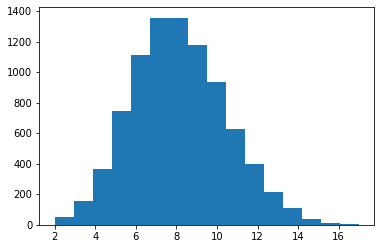

In [70]:


hist(lengths, bins=len(set(lengths)));





Длины таких слов распределены похоже на нормальное распределение :)


In [72]:
def pdist_good_turing_hack(counter, onecounter, base=1/26., prior=1e-8):
    """Вероятность слова при условии данных из счетчика.
    Для неизвестных слов, смотрим на слова, встретившиеся единожды из onecounter, 
    вероятность выбираем, основываясь на длине.
    Воспользуемся идеей метода Гуда-Тьюринга(полностью мы его здесь не реализуем).
    prior -добавочный фактор, который сделает неизвестные слова менее вероятными.
    base -то, насколько мы уменьшаем вероятность за длину слова больше максимального."""
    N = sum(list(counter.values()))
    N2 = sum(list(onecounter.values()))
    lengths = list(map(len, [w for w in onecounter if onecounter[w] == 1]))
    ones = Counter(lengths)
    longest = max(ones)
    return (lambda word: 
            counter[word] / N if (word in counter) 
            else prior * (ones[len(word)] / N2 or 
                          ones[longest] / N2 * base ** (len(word)-longest)))
#Переопределим P1w
P1w = pdist_good_turing_hack(COUNTS1, COUNTS)

In [73]:
segment.cache.clear()
segment('thisisatestofsegmentationofaverylongsequenceofwords')


['this',
 'is',
 'a',
 'test',
 'of',
 'segmentation',
 'of',
 'a',
 'very',
 'long',
 'sequence',
 'of',
 'words']


(11) Задача: Что если слово находится очень далеко по edit_distance, но звучит точно так же?

Часто можно встретить ошибки в текстах, вызванные неграмотным написанием слов. Особенно часто это происходит в случае иностранных фамилий или транслитерированной терминологии. Обычно в таких случаях в пример приводят написание фамилии

Schwartzenegger

в виде:

Shwarzenegger, Shwortsinneger, schwartzineger ... und so weiter

Для такого случая можно использовать следующую методологию. Давайте привлечем лингвистов и составим правила, которые одинаково звучащим словам будут ставить в соответствие один и тот же код. Допустим, с помощью лингвистов мы такой алгоритм придумали. Тогда дальнейшие наши действия таковы:

1) Сделать словарь с вероятностями слов (как мы делали из мешка слов)

2) Сделать словарь соответствий код слова -> слово (с помощью того самого алгоритма от лингвистов). 
    Если есть в списке есть слова с одинаковым кодом, выбирать будем наиболее частое слово.

3) Сделаем аналогичный edit_distance алгоритм на множестве кодов слов

4) Найдя соответствующую замену для слова в виде его кода, восстановим слово с помощью словаря из пункта 2

Алгоритм, про который мы поговорим, называется Double Metaphone. Примеры есть тут. Перейдем к делу, посмотрим, как это работает.



In [75]:
from metaphone import doublemetaphone



Алгоритм возвращает кортеж из двух возможных фонетических кодов слова. Правило такое:

# (Primary Key = Primary Key) = Идеальное совпадение
# (Secondary Key = Primary Key) = Совпадение
# (Primary Key = Secondary Key) = Совпадение
# (Alternate Key = Alternate Key) = Совпадение +-

Идельное совпадение


In [76]:
print(doublemetaphone("Günther Graß"))
print(doublemetaphone("Günther Grass"))

('KN0RKRS', 'KNTRKRS')
('KN0RKRS', 'KNTRKRS')


In [77]:
print(doublemetaphone("schwartzenegger"))
print(doublemetaphone("shwortsineger"))

('XRTSNKR', 'XFRTSNKR')
('XRTSNJR', 'XRTSNKR')


In [78]:


print(doublemetaphone("xerox"))
print(doublemetaphone("zeeerux"))



('SRKS', '')
('SRKS', '')


Полезные ссылки